# Laboration maskininlärning AI22

## 1.0 - Uppvärmning
recommender_test.ipynb

## 1.1 - Movielens full - EDA

In [1]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

y:\Skola\OOP\Skolarbete\AI-Erik-Johansson-OPA23\venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [57]:
movies='data/large/movies.csv'
ratings='data/large/ratings.csv'

df_movies=pd.read_csv(movies, usecols=['movieId', 'title'], dtype={'movieId' : 'int32', 'title' : 'str'})
df_ratings=pd.read_csv(ratings, usecols=['userId', 'movieId', 'rating'], dtype={'userId':'int32', 'movieId':'int32', 'rating':'float32'})

In [56]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int32 
 1   title    86537 non-null  object
dtypes: int32(1), object(1)
memory usage: 1014.2+ KB


In [5]:
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0


In [6]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 387.2 MB


### b)

In [33]:
df_ratings["movieId"].value_counts()[:10]

movieId
318     122296
356     113581
296     108756
2571    107056
593     101802
260      97202
2959     86207
527      84232
480      83026
1196     80200
Name: count, dtype: int64

In [46]:
most_rated = df_ratings["movieId"].value_counts()[:10].index.to_list()
most_rated

[318, 356, 296, 2571, 593, 260, 2959, 527, 480, 1196]

In [47]:
print("Top 10 movies by number of ratings:")
for m in most_rated:
    print(df_movies[df_movies["movieId"] == m]["title"].values[0])

Top 10 movies by number of ratings:
Shawshank Redemption, The (1994)
Forrest Gump (1994)
Pulp Fiction (1994)
Matrix, The (1999)
Silence of the Lambs, The (1991)
Star Wars: Episode IV - A New Hope (1977)
Fight Club (1999)
Schindler's List (1993)
Jurassic Park (1993)
Star Wars: Episode V - The Empire Strikes Back (1980)


### c)

In [54]:
print("Average rating for top 10 most rated movies:")
for m in most_rated:
    print(df_movies[df_movies["movieId"] == m]["title"].values[0],"Rating: ", round(df_ratings[df_ratings["movieId"] == m]["rating"].mean(), 2))

Average rating for top 10 most rated movies:
Shawshank Redemption, The (1994) Rating:  4.42
Forrest Gump (1994) Rating:  4.07
Pulp Fiction (1994) Rating:  4.19
Matrix, The (1999) Rating:  4.16
Silence of the Lambs, The (1991) Rating:  4.15
Star Wars: Episode IV - A New Hope (1977) Rating:  4.09
Fight Club (1999) Rating:  4.24
Schindler's List (1993) Rating:  4.24
Jurassic Park (1993) Rating:  3.69
Star Wars: Episode V - The Empire Strikes Back (1980) Rating:  4.12


In [74]:
for year in range(1870, 2024):
    number = df_movies[df_movies["title"].str.contains(f"{year}")]["movieId"].count()
    print(year, number)

1870 1
1871 1
1872 0
1873 0
1874 1
1875 0
1876 0
1877 0
1878 2
1879 0
1880 2
1881 0
1882 1
1883 1
1884 0
1885 1
1886 0
1887 3
1888 4
1889 1
1890 5
1891 6
1892 3
1893 0
1894 27
1895 19
1896 59
1897 35
1898 21
1899 30
1900 55
1901 45
1902 20
1903 32
1904 17
1905 19
1906 28
1907 33
1908 27
1909 24
1910 19
1911 20
1912 39
1913 47
1914 61
1915 43
1916 48
1917 36
1918 34
1919 47
1920 50
1921 57
1922 57
1923 40
1924 54
1925 65
1926 80
1927 80
1928 102
1929 155
1930 172
1931 229
1932 268
1933 269
1934 256
1935 287
1936 310
1937 292
1938 255
1939 259
1940 262
1941 278
1942 304
1943 258
1944 256
1945 253
1946 253
1947 280
1948 300
1949 329
1950 338
1951 329
1952 349
1953 364
1954 356
1955 377
1956 360
1957 392
1958 378
1959 364
1960 328
1961 358
1962 352
1963 391
1964 449
1965 437
1966 483
1967 463
1968 544
1969 535
1970 587
1971 624
1972 651
1973 602
1974 626
1975 538
1976 600
1977 582
1978 569
1979 590
1980 570
1981 550
1982 566
1983 561
1984 568
1985 620
1986 658
1987 730
1988 748
1989 786
19

In [84]:
years = range(1874, 2024)
films_per_year = [df_movies[df_movies["title"].str.contains(f"({y})", regex=False)]["movieId"].count() for y in years]
films_per_year

[1,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 3,
 4,
 1,
 5,
 6,
 3,
 0,
 27,
 19,
 58,
 34,
 19,
 30,
 53,
 45,
 20,
 32,
 17,
 19,
 28,
 33,
 27,
 24,
 19,
 19,
 38,
 46,
 60,
 41,
 48,
 34,
 31,
 46,
 46,
 56,
 56,
 40,
 53,
 65,
 80,
 80,
 102,
 155,
 172,
 229,
 268,
 269,
 256,
 285,
 308,
 290,
 254,
 258,
 262,
 275,
 302,
 257,
 253,
 249,
 253,
 280,
 300,
 328,
 337,
 328,
 348,
 363,
 356,
 376,
 360,
 392,
 378,
 363,
 327,
 358,
 352,
 389,
 447,
 437,
 482,
 461,
 542,
 534,
 585,
 623,
 649,
 601,
 623,
 536,
 598,
 580,
 566,
 589,
 567,
 549,
 561,
 560,
 558,
 616,
 658,
 726,
 746,
 781,
 687,
 685,
 702,
 709,
 777,
 855,
 861,
 944,
 947,
 985,
 1125,
 1155,
 1233,
 1235,
 1425,
 1554,
 1765,
 1864,
 1964,
 2066,
 2053,
 2188,
 2383,
 2609,
 2875,
 3045,
 3144,
 3232,
 3172,
 3058,
 2628,
 2297,
 1962,
 556]

In [82]:
df_movies[df_movies["title"].str.contains(f"({1900})", regex=False)]

,movieId,title
23423,117909,The Kiss (1900)
37918,152908,Panorama of Eiffel Tower (1900)
37919,152910,Eiffel Tower from Trocadero Palace (1900)
37920,152912,Palace of Electricity (1900)
37921,152914,Champs de Mars (1900)
37922,152916,Scene from the Elevator Ascending Eiffel Tower...
47819,174105,Grandma's Reading Glass (1900)
47820,174107,Let Me Dream Again (1900)
47826,174121,"Bombardment of Taku Forts, by the Allied Fleet..."
47828,174125,"Bird's-Eye View of Dock Front, Galveston (1900)"


<Axes: >

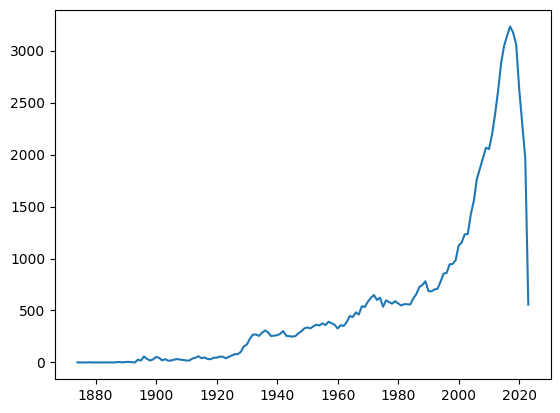

In [87]:
import seaborn as sns

sns.lineplot(x=years, y=films_per_year)